# Products Recommendation System
### This dataset contains the below 10 columns: ###
1. index – the serial number 
2. product – Title (or name) of the product
3. category – Category of the product
4. sub_category – Subcategory of the product
5. brand – Brand of the product
6. sale_price – Price at which product is being sold on the site
7. market_price – The market price of the product
8. type – Type into which product falls
9. rating – aggregate product rating (out of 5) by customers
10. description – Description of the product

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Text handling libraries
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('data\BigBasket Products.csv')
df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [3]:
df.shape

(27555, 10)

### EDA and Data Cleaning ###

In [4]:
print('Null Data Count in Each Column')
print('-'*30)
print(df.isnull().sum())

Null Data Count in Each Column
------------------------------
index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64


In [5]:
print('Null Data % in Each Column')
print('-'*30)
print(round((df.isnull().sum()/len(df))*100, 2))

Null Data % in Each Column
------------------------------
index            0.00
product          0.00
category         0.00
sub_category     0.00
brand            0.00
sale_price       0.00
market_price     0.00
type             0.00
rating          31.30
description      0.42
dtype: float64


### Findings from the EDA: ###

* There is a product without a name.
* There is a product without a brand.
* 115 products do not have a description.
* 8626 products do not have ratings.
* The above features are important for building a recommendation system. So, we will drop the rows from data that contain missing values.

In [6]:
df = df.dropna()
df = df.drop(columns='index')
df.shape

(18840, 9)

* Even after dropping nulls, we have a good data size of 18840 records.

In [7]:
df.dtypes

product          object
category         object
sub_category     object
brand            object
sale_price      float64
market_price    float64
type             object
rating          float64
description      object
dtype: object

**Findings from this step**  : The features sale_price, market_price, and rating are numeric (as they are represented using float64). The rest are all string features (represented as objects).

### Univariate Analysis in Recommendation System ###

Here, we will understand the data distribution of several columns. A look at category column distribution

In [8]:
counts = df['category'].value_counts()
count_percentage = df['category'].value_counts(normalize=True)*100
counts_df = pd.DataFrame({'Category': counts.index, 'Count': counts.values, 'Percent': np.round(count_percentage.values,2)})
print(counts_df)

                   Category  Count  Percent
0          Beauty & Hygiene   5460    28.98
1    Kitchen, Garden & Pets   2494    13.24
2    Snacks & Branded Foods   2468    13.10
3      Gourmet & World Food   2364    12.55
4  Foodgrains, Oil & Masala   2173    11.53
5      Cleaning & Household   2091    11.10
6     Bakery, Cakes & Dairy    665     3.53
7                 Beverages    630     3.34
8                 Baby Care    495     2.63


In [9]:
px.bar(data_frame=counts_df,
      x='Category',
      y='Count',
      color='Count',
      color_continuous_scale='greens',
      text_auto=True,
      title='Count of Items in each category')

### Findings: ###
* Beauty and Hygiene have a total of 5460 products. It covers 28.98% of the total product portfolio.
* Next, the best category is Kitchen, Garden, and Pets, which has 2494 products. It covers 13.24% of the total product portfolio.
* Baby care has the lowest product count of 495 products. It covers 2.63% of the total product portfolio.

In [10]:
# A Look at sub category column distribution

counts = df['sub_category'].value_counts()
count_percentage = df['sub_category'].value_counts(normalize=True)*100
counts_df = pd.DataFrame({'Sub Category':counts.index, 'Counts':counts.values, 'Percent':np.round(count_percentage.values,2)})
print('Unique sub categories values ',df['sub_category'].nunique())
print('Top 10 sub_category')
display(counts_df.head())
print('Bottom 10 sub categories')
display(counts_df.tail(10))

Unique sub categories values  77
Top 10 sub_category


,Sub Category,Counts,Percent
0,Skin Care,1641,8.71
1,Hair Care,818,4.34
2,Bath & Hand Wash,808,4.29
3,Masalas & Spices,764,4.06
4,Storage & Accessories,658,3.49


Bottom 10 sub categories


,Sub Category,Counts,Percent
67,Flask & Casserole,39,0.21
68,Car & Shoe Care,39,0.21
69,Bakeware,37,0.20
70,Non Dairy,31,0.16
71,Baby Accessories,27,0.14
72,Bakery Snacks,24,0.13
73,Mothers & Maternity,23,0.12
74,Water,16,0.08
75,Gourmet Breads,10,0.05
76,Cuts & Sprouts,1,0.01


In [11]:
px.bar(data_frame=counts_df,
       x='Sub Category',
       y='Counts',
       color='Counts',
       color_continuous_scale='Viridis',
       text_auto=True,
       title='Count of Items in each category',
       width=1200)

In [12]:
px.bar(data_frame=counts_df[:10],
      x='Sub Category',
      y='Counts',
      color='Counts',
      color_continuous_scale='blues',
      text_auto=True,
      title='Top 10 Bought Sub_Categories')

In [13]:

px.bar(data_frame=counts_df[-10:],
      x='Sub Category',
      y='Counts',
      color='Counts',
      color_continuous_scale='blues',
      text_auto=True,
      title='Bottom 10 Bought Sub_Categories')

### Findings: ###
* There are 77 unique sub_category values.
* Skin Care has a total of 1641 products. It covers 8.71% of the total product portfolio.
* The next best sub_category is Hair Care which has a total of 818 products. - It covers 4.34% of the total product portfolio.
* Cuts & Sprouts has the lowest product count of 1 product. It barely covers 0.01% of the total product portfolio.

In [14]:
# A Look at brand column distribution

column = 'brand'
counts = df[column].value_counts()
count_percentage = df[column].value_counts(1)*100
counts_df = pd.DataFrame({column:counts.index, 'Counts': counts.values, 'Percent':np.round(count_percentage.values,2)})
print('unique'+str(column)+' values', df['brand'].nunique())
print('Top 10 '+str(column))
display(counts_df.head(10))
print('Bottom 10 '+str(column))
display(counts_df.tail(10))

uniquebrand values 1933
Top 10 brand


,brand,Counts,Percent
0,bb Royal,278,1.48
1,BB Home,172,0.91
2,Amul,153,0.81
3,Himalaya,139,0.74
4,Cello,104,0.55
5,BIOTIQUE,103,0.55
6,DP,101,0.54
7,Keya,101,0.54
8,Organic Tattva,99,0.53
9,MTR,97,0.51


Bottom 10 brand


,brand,Counts,Percent
1923,Diabetics Dezire,1,0.01
1924,Kerala,1,0.01
1925,Cetaphil,1,0.01
1926,Popular Essentials,1,0.01
1927,Sanitt,1,0.01
1928,Fazlani,1,0.01
1929,Fakira,1,0.01
1930,Sofia,1,0.01
1931,Dr. Schar,1,0.01
1932,4700BC,1,0.01


In [15]:
px.bar(data_frame=counts_df.head(10),
       x=column,
       y='Counts',
       color='Counts',
       color_continuous_scale='Plasma',
       text_auto=True,
       title=f'Top 10 Brand Items based on Item Counts',
       width=1000) 


In [16]:
len(counts_df[counts_df['Counts']==1])

494

### Findings: ###
* There are 1933 unique values for brands.
* There are 494 brands having a single product.
* The top 2 brands are of BigBasket.
* bb Royal has a total of 278 products. It covers 1.48% of the total product portfolio.
* The next best brand is BB Home, which has 172 products. It covers 0.91% of the total product portfolio.

In [17]:
# A Look at type column distribution

counts = df['type'].value_counts()
count_percentage = df['type'].value_counts(1)*100
counts_df = pd.DataFrame({'Type': counts.index, 'Counts': counts.values, 'Percent': np.round(count_percentage.values,2)})
print('Unique type values: ', df['type'].nunique())
print('Top 10 types')
display(counts_df[:10])

Unique type values:  358
Top 10 types


,Type,Counts,Percent
0,Face Care,1094,5.81
1,Men's Deodorants,404,2.14
2,Shampoo & Conditioner,390,2.07
3,Blended Masalas,343,1.82
4,Containers Sets,332,1.76
5,Bathing Bars & Soaps,322,1.71
6,Glassware,263,1.40
7,Body Care,251,1.33
8,Namkeen & Savoury Snacks,234,1.24
9,Hand Wash & Sanitizers,212,1.13


In [18]:
import plotly.express as px

px.bar(data_frame=counts_df.head(10),
       x='Type',
       y='Counts',
       color='Counts',
       color_continuous_scale='Viridis',
       text_auto=True,
       title='Top 10 types of products based on Item counts',
       width=1000)


In [19]:
len(counts_df[counts_df['Counts']==1])

9

### Findings: ###
* There are 358 unique values for type.
* There are 9 types having a single product.
* Face Care has a total of 1094 products. It covers 5.81% of the total product portfolio.
* Next, the best type is Men’s Deodorant, which has 404 products. It covers 2.14% of the total product portfolio.

### Rating Analysis ##
Since this is a numeric column, Lets look at the histogram of this column.

count    18840.000000
mean         3.943063
std          0.739646
min          1.000000
25%          3.700000
50%          4.100000
75%          4.300000
max          5.000000
Name: rating, dtype: float64


<Axes: >

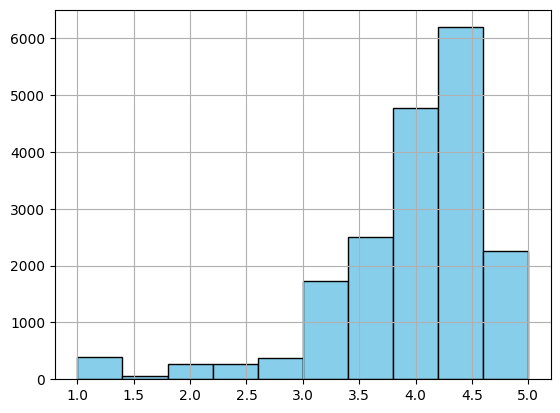

In [20]:
print(df['rating'].describe())
df['rating'].hist(bins=10, color='skyblue', edgecolor='black')

* We can see that histogram is skewed towards the right, which means that most of the products have a higher rating.
* How many Ratings are between the interval of 0 to 1, 1 to 2, and so on?

In [21]:
pd.cut(df.rating, bins=[0,1,2,3,4,5]).reset_index().groupby(['rating']).count()

,index
rating,
"(0, 1]",387
"(1, 2]",335
"(2, 3]",1347
"(3, 4]",6559
"(4, 5]",10212


### Findings: ###
* 10212 products had a rating between 4 and 5.
* 387 products had a rating between 0 and 1.

### Feature Engineering for Recommendation System ###
Here, we can create new features which can improve the recommendations. We have the sale_price and market_price. Let’s create a feature discount%

In [22]:
df['discount'] = (df['market_price']-df['sale_price'])*100/df['market_price']
print(df['discount'].describe())

pd.cut(df.discount, bins=[-1,0,10,20,30,40,50,60,80,90,100]).reset_index().groupby(['discount']).count()

count    18840.000000
mean        11.751733
std         14.546937
min          0.000000
25%          0.000000
50%          5.000000
75%         20.000000
max         82.506266
Name: discount, dtype: float64


,index
discount,
"(-1, 0]",8157
"(0, 10]",3125
"(10, 20]",2962
"(20, 30]",2435
"(30, 40]",1126
"(40, 50]",700
"(50, 60]",223
"(60, 80]",108
"(80, 90]",4


* Since this is a numeric column, Let’s look at the histogram of this column.

<Axes: >

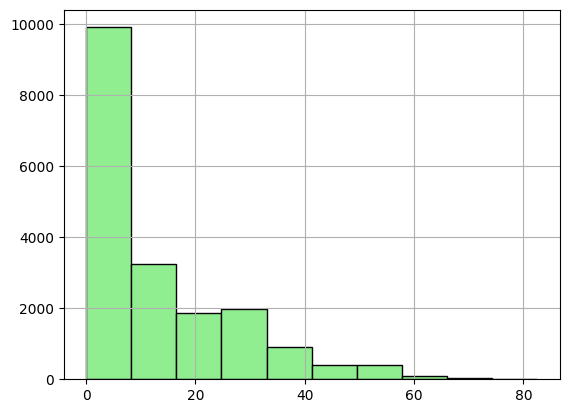

In [23]:
df['discount'].hist(color='lightgreen', edgecolor='black')

### Findings: ###
* 8157 products do not have any discount.
* At least 4 products have above 80% discount.

### Bivariate Analysis ###
* Is there any relation between rating and discount?

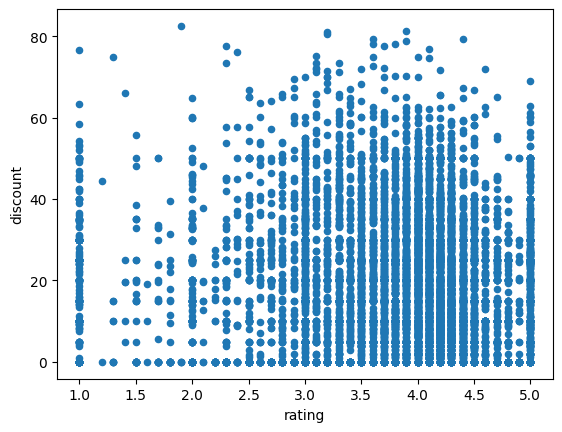

In [24]:
ax = df.plot.scatter(x='rating', y='discount')

**Findings**: Looking at the scatter plot, we do not see any association between rating and discount.

### Let's clean a Few String columns ###
The category column contains ‘Kitchen, Garden & Pets.’ We will clean it, so it contains [kitchen, garden, pets]. A similar transformation will be applied to sub_category, type, and brand features. Now, let’s create one feature (product_classification_features) which appends all the above 4 cleaned columns.

In [25]:
df2 = df.copy()
rmv_spc = lambda a:a.strip()
get_list = lambda a:list(map(rmv_spc,re.split('& |, |\\*', a)))
for col in ['category', 'sub_category', 'type']:
    df2[col] = df2[col].apply(get_list)
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
for col in ['category', 'sub_category', 'type','brand']:
    df2[col] = df2[col].apply(cleaner)
def couple(x):
    return ' '.join(x['category']) + ' ' + ' '.join(x['sub_category']) + ' '+x['brand']+' ' +' '.join( x['type'])
df2['product_classification_features'] = df2.apply(couple, axis=1)

In [26]:
df2.head(3)

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,discount,product_classification_features
0,Garlic Oil - Vegetarian Capsule 500 mg,"[beauty, hygiene]",[haircare],srisriayurveda,220.0,220.0,"[hairoil, serum]",4.1,This Product contains Garlic Oil that is known...,0.0,beauty hygiene haircare srisriayurveda hairoil...
1,Water Bottle - Orange,"[kitchen, garden, pets]","[storage, accessories]",mastercook,180.0,180.0,"[water, fridgebottles]",2.3,"Each product is microwave safe (without lid), ...",0.0,kitchen garden pets storage accessories master...
2,"Brass Angle Deep - Plain, No.2","[cleaning, household]",[poojaneeds],trm,119.0,250.0,"[lamp, lampoil]",3.4,"A perfect gift for all occasions, be it your m...",52.4,cleaning household poojaneeds trm lamp lampoil


In [27]:
def recommend_most_popular(col, col_value, top_n=5):
    return df[df[col]==col_value].sort_values(by='rating', ascending=False).head(top_n)[['product', col, 'rating']]

In [28]:
recommend_most_popular(col='category',col_value='Cleaning & Household')

,product,category,rating
7941,Perfecto Geometry Box Set,Cleaning & Household,5.0
16612,Food Safe Wipes,Cleaning & Household,5.0
13168,Japanese Cypress Plant Based Liquid Laundry De...,Cleaning & Household,5.0
25205,Glass Cleaner - Aquatic,Cleaning & Household,5.0
13185,"Wax Diya - Tulsi, Assorted Colour, ED136",Cleaning & Household,5.0


In [29]:
recommend_most_popular(col='sub_category', col_value='Hair Care')

,product,sub_category,rating
14616,Black Pearl Shampoo - Hair Loss & Dandruff Con...,Hair Care,5.0
8274,"De-Tangling Comb - 1 Row, 1266",Hair Care,5.0
14555,Argan Oil Shampoo,Hair Care,5.0
14440,Blooming Colour Shampoo - Murumuru Butter & Ro...,Hair Care,5.0
13069,Hair Repair Conditioner,Hair Care,5.0


Let’s look at the most popular products for the brand = Amul

In [30]:
recommend_most_popular(col='brand',col_value='Amul')

,product,brand,rating
16466,Vanilla Milkshake,Amul,5.0
10430,Spray Infant Milk Food/Substitute,Amul,4.5
5856,Almondo - Roasted Almonds Coated With Milk Cho...,Amul,4.5
9399,Amulya Dairy Whitener,Amul,4.4
20841,"Peru Dark Amazon, Single Origin Dark Chocolate...",Amul,4.4


Let’s calculate the cosine similarity of the product_classification_features for all the products.

In [31]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['product_classification_features'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18830,18831,18832,18833,18834,18835,18836,18837,18838,18839
0,1.000000,0.0,0.000000,0.000000,0.308607,0.000000,0.365148,0.272166,0.500000,0.000000,...,0.000000,0.0,0.0,0.500000,0.0,0.333333,0.0,0.0,0.0,0.272166
1,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,1.000000,0.308607,0.000000,0.333333,0.000000,0.000000,0.000000,0.272166,...,0.288675,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.308607,1.000000,0.000000,0.308607,0.000000,0.000000,0.000000,0.251976,...,0.267261,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.308607,0.0,0.000000,0.000000,1.000000,0.000000,0.338062,0.629941,0.308607,0.000000,...,0.000000,0.0,0.0,0.308607,0.0,0.308607,0.0,0.0,0.0,0.251976


The above matrix contains the cosine similarity of each product vs the rest of the products in catalog. Let’s build a recommender using cosine similarity

In [32]:
def content_recommendation(title):
    a = df2.copy()
    index = a[a['product']==title].index[0]
    top_n_index = list(cosine_sim_df[index].nlargest(10).index)
    top_n_index.remove(index)
    similar_df = a.iloc[top_n_index][['product']]
    similar_df['Cosine_similarity'] = cosine_sim_df[index].iloc[top_n_index].values
    return similar_df

In [33]:
# Let’s see the recommendations for a few products.

title = 'Water Bottle - Orange'
content_recommendation(title)

,product,Cosine_similarity
139,Glass Water Bottle - Aquaria Organic Purple,0.875
1038,Glass Water Bottle With Round Base - Transpare...,0.875
1701,H2O Unbreakable Water Bottle - Pink,0.875
2209,Water Bottle H2O Purple,0.875
2704,H2O Unbreakable Water Bottle - Green,0.875
2908,Regel Tritan Plastic Sports Water Bottle - Black,0.875
3225,Apsara 1 Water Bottle - Assorted Colour,0.875
3481,"Glass Water Bottle With Round Base - Yellow, B...",0.875
3669,Trendy Stainless Steel Bottle With Steel Cap -...,0.875


### Findings: ###
* In this example, we can recommend bottles. However, we are recommending all the colors.
* Also, the cosine similarity is the same for all the recommendations.

In [34]:
title = 'Brass Angle Deep - Plain, No.2'
content_recommendation(title)

,product,Cosine_similarity
2161,Brass Kachua Stand Deepam - No.1,1.0
2755,"Brass Angle Deep Stand - Plain, No.2",1.0
5399,"Brass Lakshmi Deepam - Plain, No.2",1.0
6519,Brass Kuber Deepam - No.1,1.0
7341,"Brass Deepa Matki - Round, No.3",1.0
10503,Brass Kuber Deepam - No.2,1.0
11009,"Brass Deepa Matki - Round, No.1",1.0
11225,"Brass Angle Deep Stand - Plain, No.3",1.0
11503,"Brass Angle Deep Stand - Plain, No.1",1.0


### Improving the Model ###
Let us tweak the algorithm. Let us also use the product column to create another cosine similarity. We will take the average of both the cosine similarity and see if the results are better.

In [35]:
count2 = CountVectorizer(stop_words='english', lowercase=True)
count_matrix2 = count2.fit_transform(df2['product'])
cosine_sim2 = cosine_similarity(count_matrix2, count_matrix2)
cosine_sim_df2 = pd.DataFrame(cosine_sim2)
cosine_sim_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,18830,18831,18832,18833,18834,18835,18836,18837,18838,18839
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.235702,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [36]:
def content_recommendation(title):
    a = df2.copy().reset_index().drop('index',axis=1)
    index = a[a['product']==title].index[0]
    similar_basis_metric_1 = cosine_sim_df[cosine_sim_df[index]>0][index].reset_index().rename(columns={index:'sim_1'})
    similar_basis_metric_2 = cosine_sim_df2[cosine_sim_df2[index]>0][index].reset_index().rename(columns={index:'sim_2'})
    similar_df = similar_basis_metric_1.merge(similar_basis_metric_2, how='left').merge(a[['product']].reset_index(), how='left')
    similar_df['sim'] = similar_df[['sim_1','sim_2']].fillna(0).mean(axis=1)
    similar_df = similar_df[similar_df['index']!=index].sort_values(by='sim', ascending=False)
    return similar_df[['product', 'sim']].head(10)

In [37]:
title = 'Water Bottle - Orange'
content_recommendation(title)

,product,sim
669,Sante Infuser Water Bottle - Orange,0.824798
2024,H2o Unbreakable Water Bottle - Orange,0.824798
2565,Swat Pet Water Bottle - Orange,0.824798
1912,Glass Water Bottle - Circo Orange & Lemon,0.791053
2084,Spray Glass water Bottle With Cork - Orange,0.791053
1924,Sip-It-Plastic Water Bottle,0.726175
1997,"Water Bottle - Twisty, Pink",0.726175
1290,Plastic Water Bottle - Pink,0.726175
195,Water Bottle H2O Purple,0.726175
1863,Water Bottle - Apsara 1 Assorted Colour,0.695699


**Findings:** The results are much better for this. The orange color bottles have a higher similarity.

In [38]:
title = 'Dark Chocolate- 55% Rich In Cocoa'
content_recommendation(title)

,product,sim
437,"Fruit N Nut, Dark Chocolate- 55% Rich In Cocoa",0.922577
2340,Sugar Free Dark Chocolate- 55% Rich In Cocoa,0.922577
2717,Rich Cocoa Dark Chocolate Bar,0.837500
561,Dark Chocolate,0.816228
504,Dlite Rich Cocoa Dark Chocolate Bar,0.802648
3137,Bitter Chocolate- 75% Rich In Cocoa,0.800000
2544,"Peru Dark Amazon, Single Origin Dark Chocolate...",0.782843
3148,Bournville Rich Cocoa 70% Dark Chocolate Bar,0.775562
548,"Colombia Classique Black, Single Origin Dark C...",0.769680
2941,"Tanzania Chocolat Noir, Single Origin Dark Cho...",0.769680
